In [1]:
import sys
import os
import numpy as np
import tensorflow as tf
import pennylane as qml
import pandas as pd
from matplotlib import pyplot as plt

from quantum_neural_network import qnode_entangling, qnode_strong_entangling
from stat_functions import quantitative_analysis, get_mean_left_right_error_interval, verify_distribution_wilcoxtest
from experiments_main import carregar_tabela
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MinMaxScaler



## Plot Functions

In [2]:
def plot_history(history, n_layers):
    plt.figure(figsize=(14,5), dpi=320, facecolor='w', edgecolor='k')
    plt.title(f"Loss for depth {n_layers}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(history.history['loss'], label="Loss/Epoch")
    plt.plot(history.history['val_loss'], label="Val Loss/Epoch")
    plt.xticks(range(0, len(history.history['loss'])+1, 5))
    plt.legend()
    plt.grid()
    plt.show()

    values = np.array([list(range(1, len(history.history['loss'])+1)), history.history['loss'], history.history['val_loss']])
    loss_pd = pd.DataFrame(np.transpose(values))
    loss_pd.columns = ["Epoch", "Loss", "Val Loss"]
    loss_pd = loss_pd.set_index("Epoch")
    path = os.path.abspath(os.path.join(os.getcwd(), 'analysis'))
    filename = f"loss-df-{(n_layers)}-layers.csv"
    loss_pd.to_csv(os.path.join(path,filename))

In [3]:
def plot_prediction_versus_observed(n_layers, y_test, y_pred, mean_error_normal):
    for i in range(y_test.shape[1]):
        plt.figure(figsize=(20,5), dpi=320, facecolor='w', edgecolor='k')
        plt.title("Wind speed prediction for "+str(i+1)+" hours ahead with "+str(n_layers)+" layers")
        plt.xlabel("Samples")
        plt.ylabel("Wind Speed (m/s)")
        plt.plot(y_pred[:,i], label="Predito", color='blue')
        plt.fill_between(range(y_pred.shape[0]), y_pred[:,i]-mean_error_normal[0,i], y_pred[:,i]+mean_error_normal[0,i], color='blue', alpha=0.05)
        plt.plot(y_test[:,i], label="Original", color='orange')
        plt.legend()
        plt.show()


## Importing Data

In [4]:
prev = 1

train = "data/train150_mucuri.txt"
X_all,y_all = carregar_tabela(train, prev)

n_features = X_all.shape[1]
n_instances = X_all.shape[0]
print(f"There are {n_features} features and {n_instances} instances in the train data")

test = "data/prev150_mucuri.txt"
X_test,y_test = carregar_tabela(test,prev)

n_features = X_test.shape[1]
n_instances = X_test.shape[0]
print(f"There are {n_features} features and {n_instances} instances in the test data")

There are 9 features and 549 instances in the train data
There are 9 features and 193 instances in the test data


In [5]:
X_all.head()

,Dia,Mês,Ano,Hora,Velocidade,Direção,Temperatura,Umidade,Pressão
0,30,11,2015,14,13.012139,75.105481,27.516129,72.930636,1020.422601
1,30,11,2015,15,12.726087,68.334332,27.238095,75.212121,1020.394348
2,30,11,2015,16,12.081111,64.457865,27.105263,75.741379,1020.508333
3,30,11,2015,17,11.647222,53.842100,26.305556,75.302632,1020.611000
4,30,11,2015,18,11.064444,53.945279,25.464286,76.592593,1020.866500


In [6]:
y_all[:5]

array([[12.72608696],
       [12.08111113],
       [11.64722224],
       [11.06444444],
       [10.32444445]])

## Scaling Data

In [7]:
scaler_x = MinMaxScaler(feature_range=(-1, 1))
X_all_scaled = scaler_x.fit_transform(X_all)

X_test_scaled = scaler_x.transform(X_test)

## Spliting Train, Validation and Test sets

In [8]:
train_ratio = 0.8
X_train, X_val, y_train, y_val = train_test_split(X_all_scaled, y_all, test_size=1 - train_ratio)

print("Len(Train):",len(X_train))
print("Len(Val):"  ,len(X_val))
print("Len(Test):" ,len(X_test_scaled))

Len(Train): 439
Len(Val): 110
Len(Test): 193


## Quantum Neural Network

In [9]:
n_qubits = n_features
n_layers = 2
print(f"Circuit size: {n_qubits} qubits")

Circuit size: 9 qubits


In [10]:
def create_quantum_model(n_layers, n_qubits, strong_entangling=False):
    print(f"Training with depth {n_layers}")
    weight_shapes = {"weights": (n_layers,n_qubits,3)}

    input_layer = tf.keras.layers.Input(shape=(n_qubits,))
    if strong_entangling:
        q_layer = qml.qnn.KerasLayer(qnode_strong_entangling, weight_shapes, output_dim=n_qubits)
    else:
        q_layer = qml.qnn.KerasLayer(qnode_entangling, weight_shapes, output_dim=n_qubits)
    activation=tf.keras.layers.Activation(tf.keras.activations.relu)
    output_layer = tf.keras.layers.Dense(prev,kernel_initializer='normal')

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

    model = tf.keras.models.Sequential([input_layer, q_layer, activation, output_layer])
    model.compile(loss=['mse'], optimizer=optimizer, metrics=['mae'])

    return model


In [11]:
model = create_quantum_model(n_layers, n_qubits)
model.summary()

Training with depth 2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 9)                 54        
                                                                 
 activation (Activation)     (None, 9)                 0         
                                                                 
 dense (Dense)               (None, 1)                 10        
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [12]:
es=EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
re=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=0, mode='min', min_lr=0.00001)
history_model = model.fit(X_train, y_train
                        , epochs=50, batch_size=32
                        , callbacks=[re]
                        , verbose=0
                        , validation_data=(X_val, y_val))

## Plotting Loss

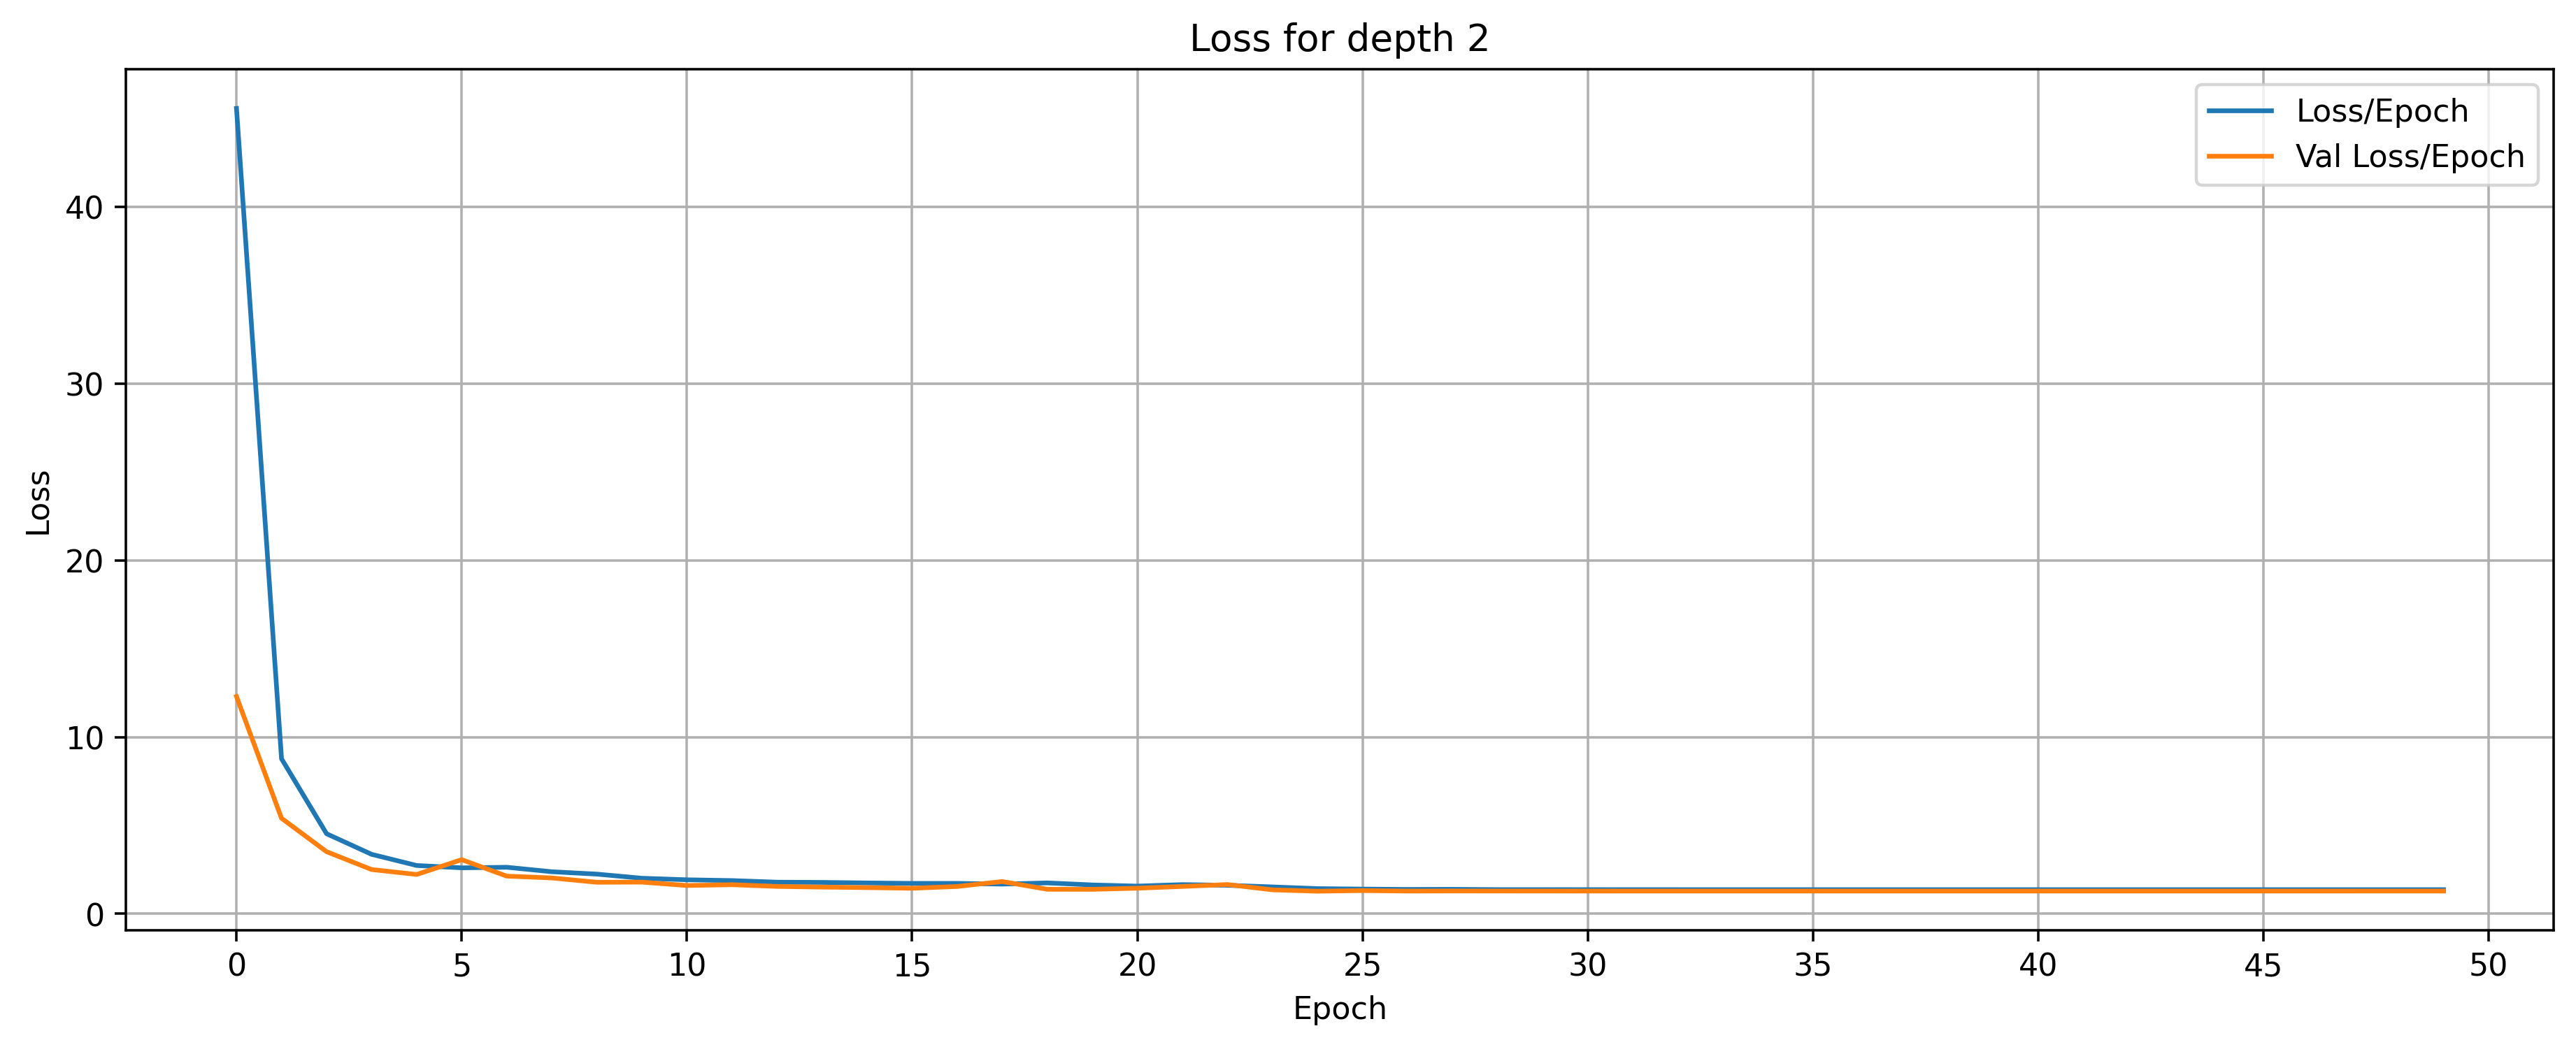

In [13]:
plot_history(history_model, n_layers)

## Prediction

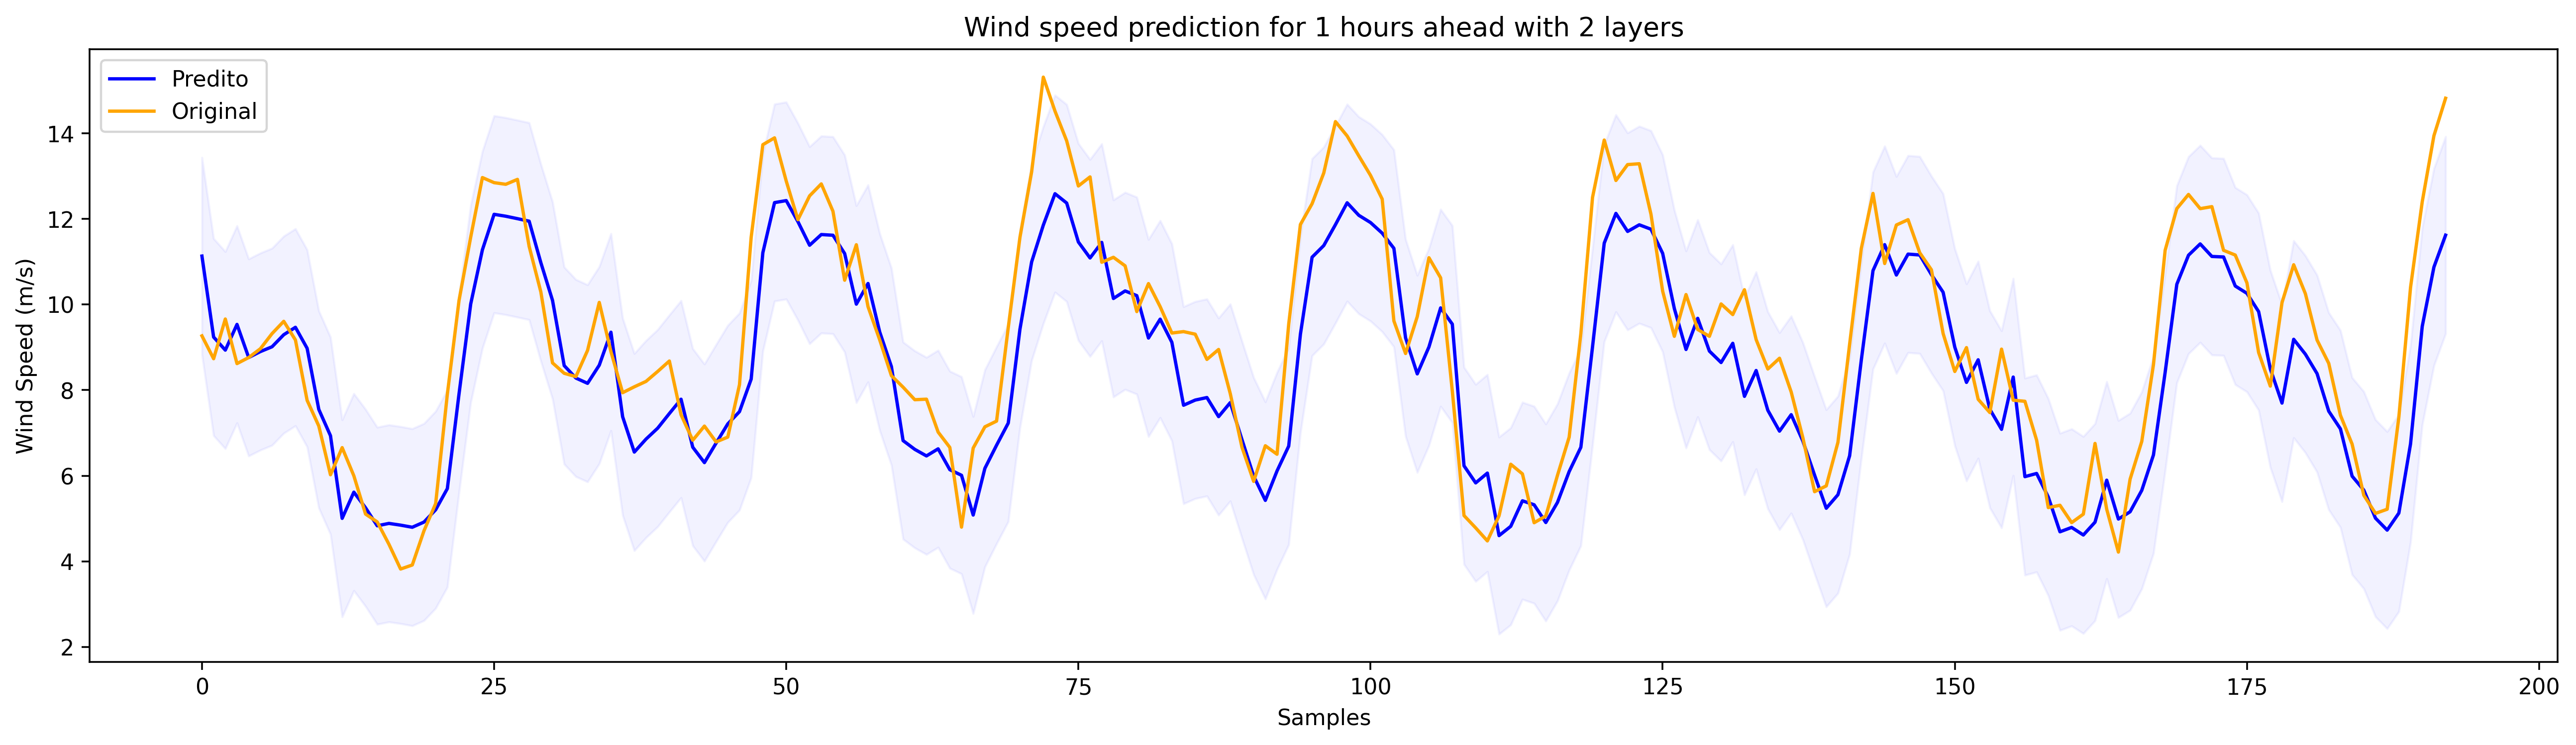

In [14]:
y_pred = model.predict(X_test_scaled,verbose=0)
mean_predictions, mean_error_normal, mean_error_left_normal, mean_error_right_normal = get_mean_left_right_error_interval(model, scaler_x, X_val, y_val, y_test, y_pred)
plot_prediction_versus_observed(n_layers, y_test, y_pred, mean_error_normal)


## Statistical Analysis

In [15]:
all_analysis = quantitative_analysis(y_test, [y_pred])
all_analysis

MAE: 1.0761331944168924
MSE: 1.8123076662113942
NMSE: 0.24782782196032485
RMSE: 1.3462197689127113
NRMSE: 0.497823082992668
R: 0.908714497786386
R²: 0.7508814081336318
Fator de 2: 1.0
              MAE       MSE      NMSE     RMSE     NRMSE         R        R²  \
Index                                                                          
1 depth  1.076133  1.812308  0.247828  1.34622  0.497823  0.908714  0.750881   
Média    1.076133  1.812308  0.247828  1.34622  0.497823  0.908714  0.750881   

         Fator de 2  
Index                
1 depth         1.0  
Média           1.0  


In [16]:
verify_distribution_wilcoxtest(y_test[:,0],y_pred[:,0], 0.05)

Statistics=3503.000, p=0.000
Different distribution (reject H0)


(3503.0, 4.755359908374484e-14)

## Creating model with strong entangling and searching for statistical difference

In [17]:
strong_model = create_quantum_model(n_layers, n_qubits, strong_entangling=True)
strong_model.summary()

Training with depth 2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 9)                 54        
                                                                 
 activation_1 (Activation)   (None, 9)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 10        
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [18]:
strong_history_model = strong_model.fit(X_train, y_train
                        , epochs=50, batch_size=32
                        , callbacks=[re]
                        , verbose=0
                        , validation_data=(X_val, y_val))

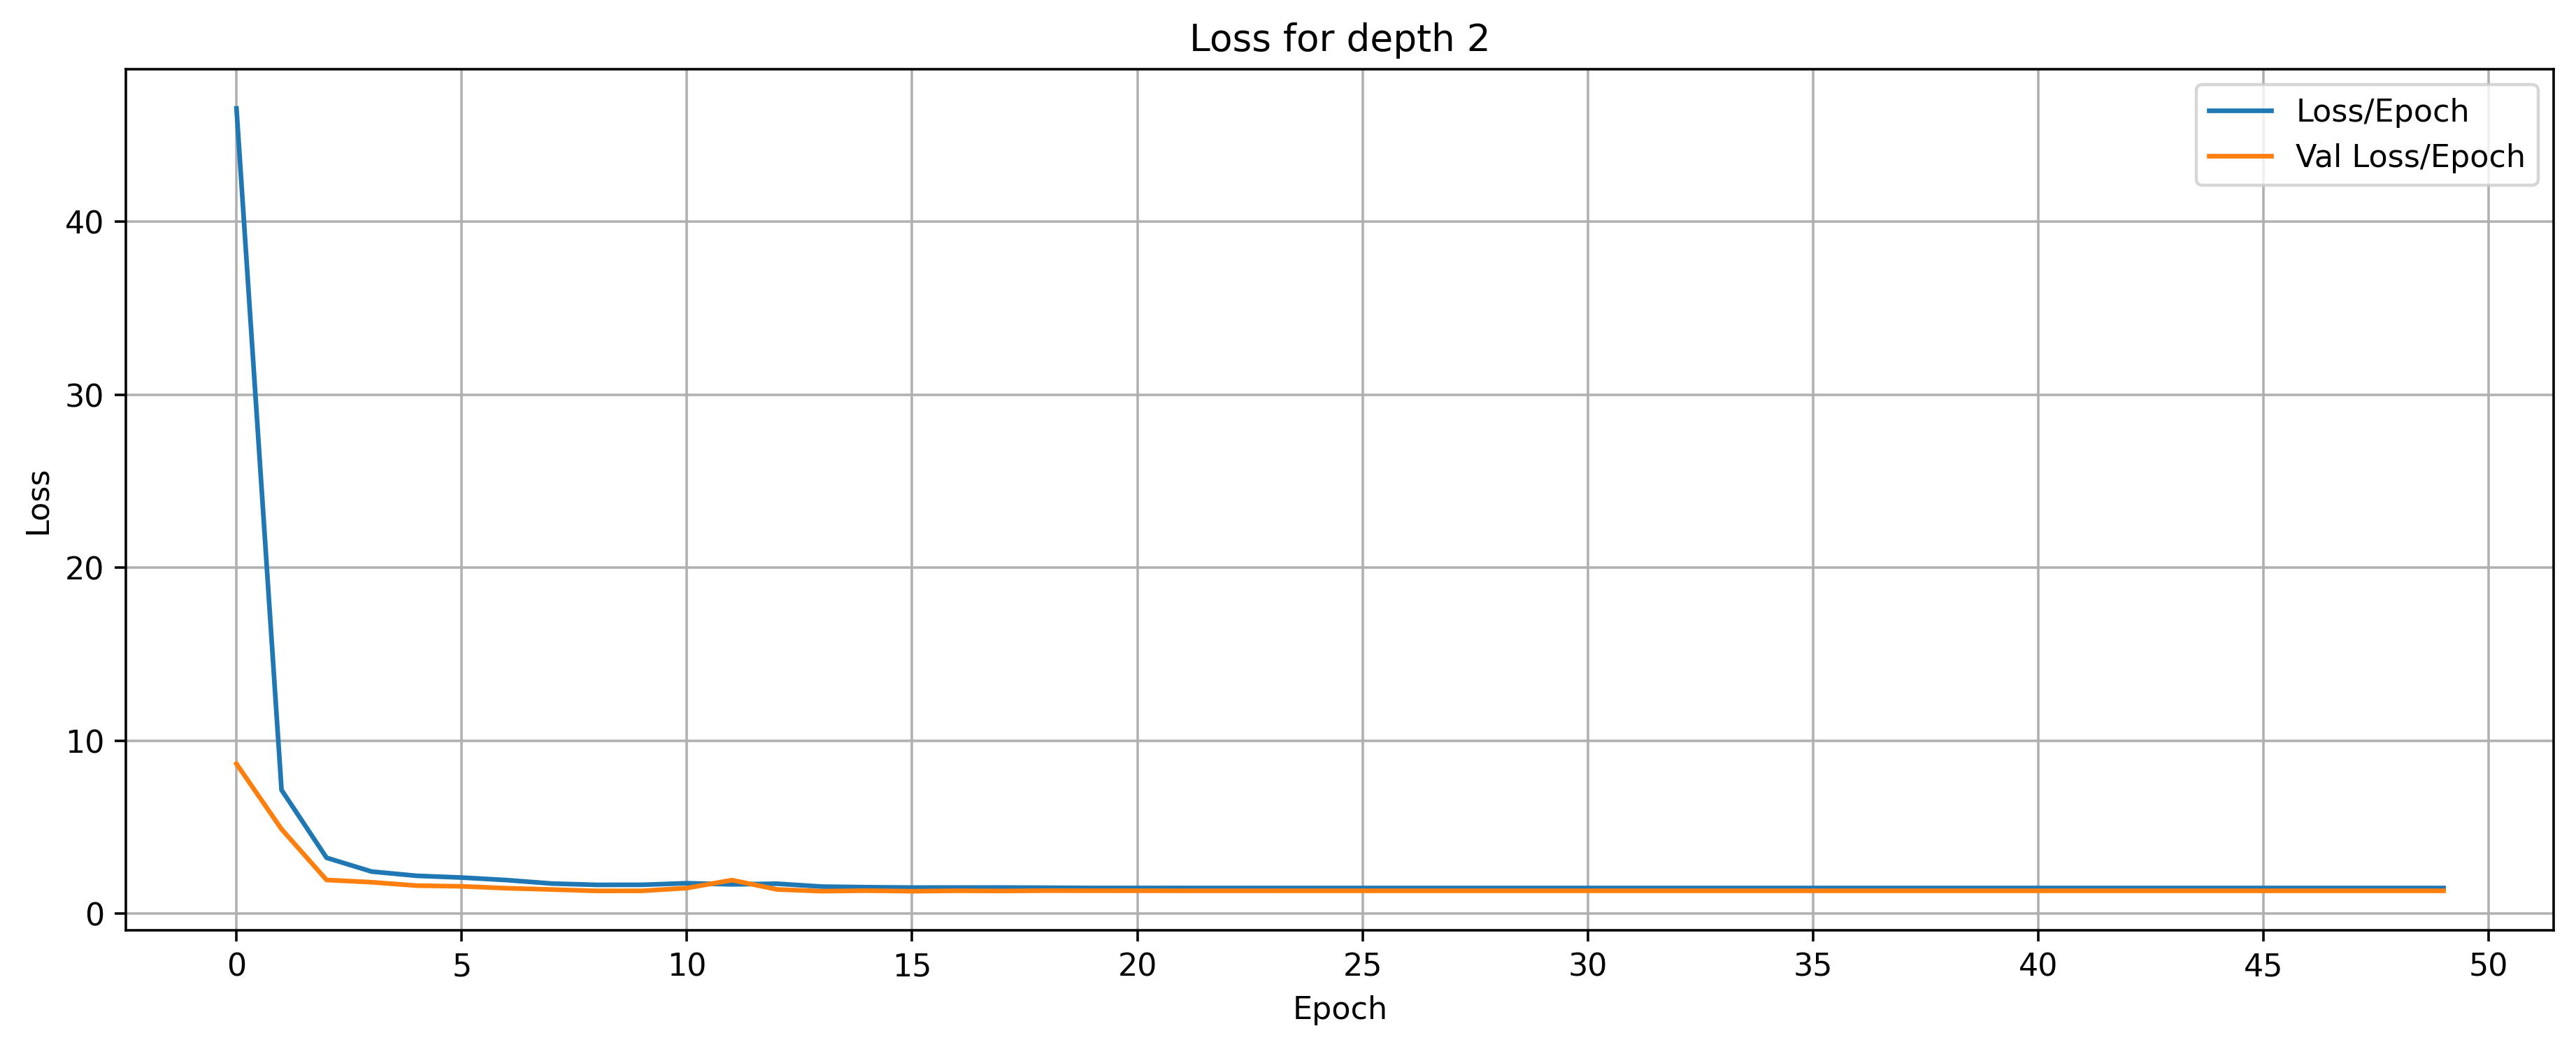

In [19]:
plot_history(strong_history_model, n_layers)

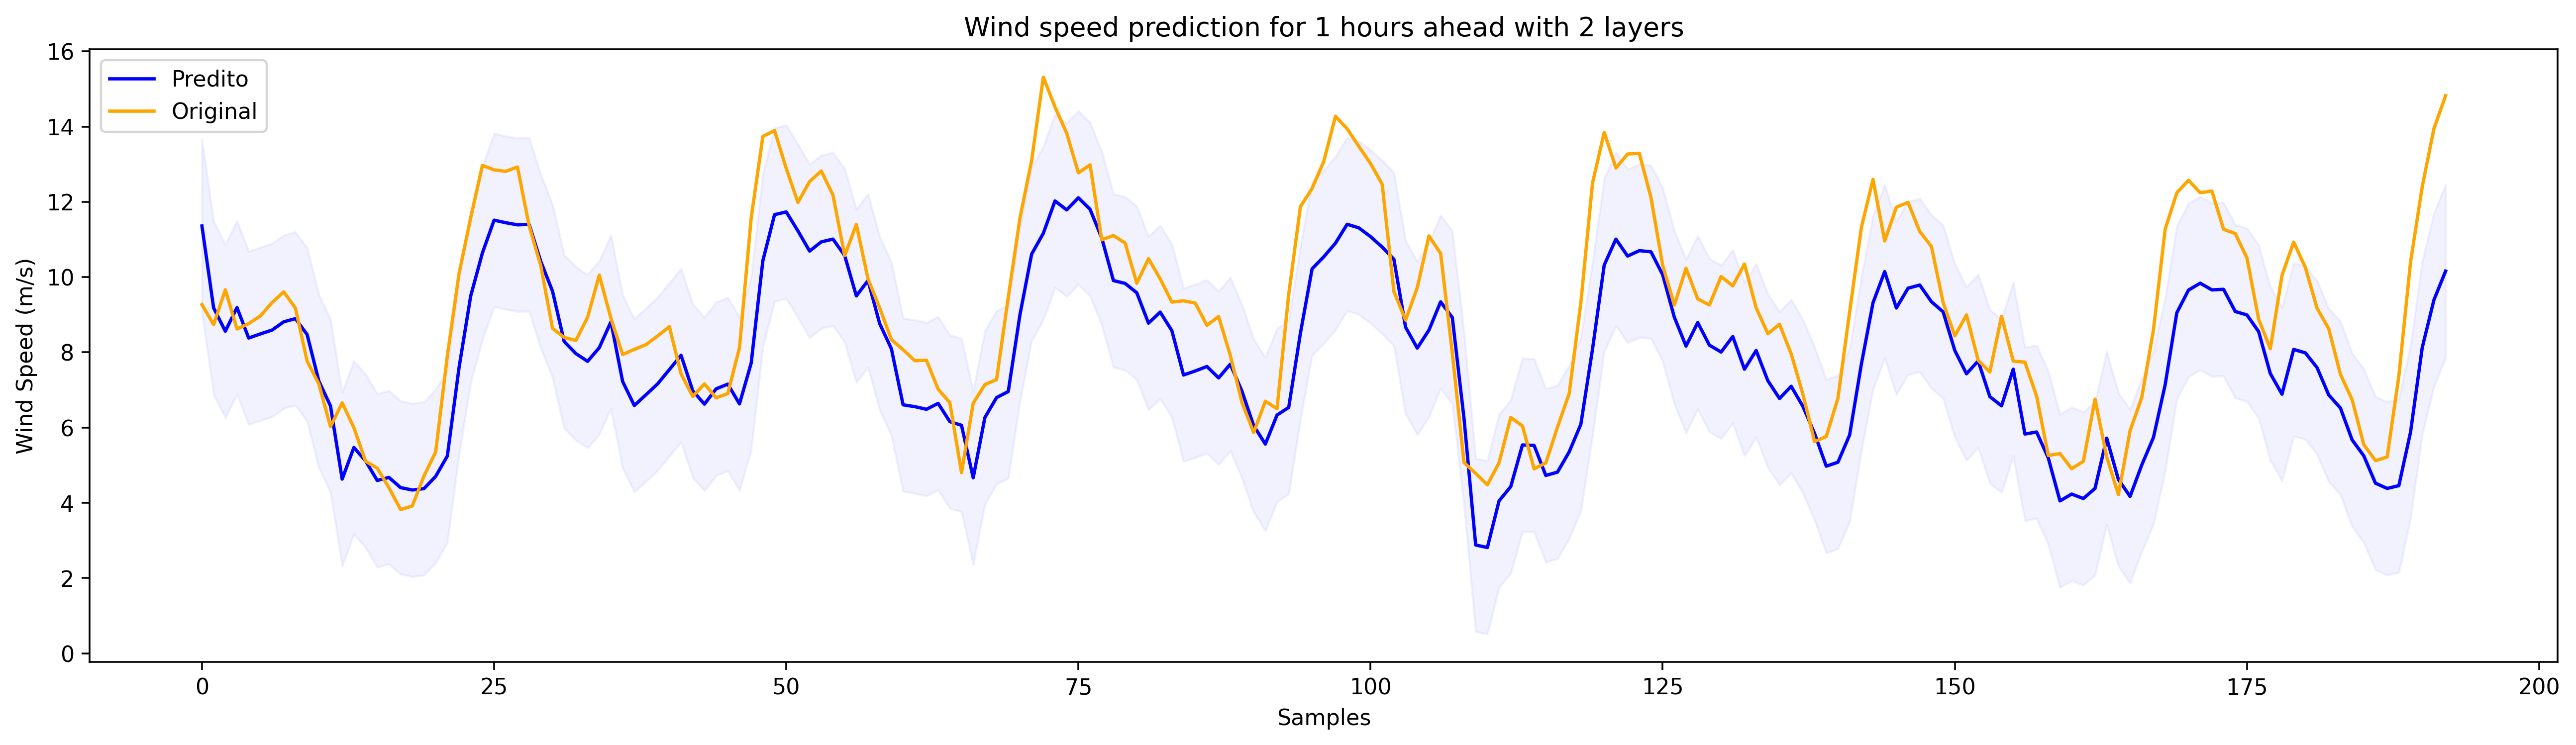

In [20]:
strong_y_pred = strong_model.predict(X_test_scaled,verbose=0)
mean_predictions, mean_error_normal, mean_error_left_normal, mean_error_right_normal = get_mean_left_right_error_interval(model, scaler_x, X_val, y_val, y_test, strong_y_pred)
plot_prediction_versus_observed(n_layers, y_test, strong_y_pred, mean_error_normal)


In [29]:
strong_analysis = quantitative_analysis(y_test, [strong_y_pred])
strong_analysis

MAE: 1.4504372077553103
MSE: 3.2943673752459226
NMSE: 0.4504951927125585
RMSE: 1.8150392214070534
NRMSE: 0.6711893866209138
R: 0.8858792251358348
R²: 0.5471584781587302
Fator de 2: 1.0


,MAE,MSE,NMSE,RMSE,NRMSE,R,R²,Fator de 2
Index,,,,,,,,
1 depth,1.450437,3.294367,0.450495,1.815039,0.671189,0.885879,0.547158,1.0
Média,1.450437,3.294367,0.450495,1.815039,0.671189,0.885879,0.547158,1.0


In [22]:
verify_distribution_wilcoxtest(y_pred[:,0],strong_y_pred[:,0], 0.05)

Statistics=682.000, p=0.000
Different distribution (reject H0)


(682.0, 5.781157201951406e-29)

## Creating deeper model and searching for statistical difference

In [23]:
n_layers = 6
model2 = create_quantum_model(n_layers, n_qubits, strong_entangling=False)
model2.summary()

Training with depth 5
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 9)                 135       
                                                                 
 activation_2 (Activation)   (None, 9)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 10        
                                                                 
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________


In [24]:
history_model2 = model2.fit(X_train, y_train
                        , epochs=50, batch_size=32
                        , callbacks=[re]
                        , verbose=0
                        , validation_data=(X_val, y_val))

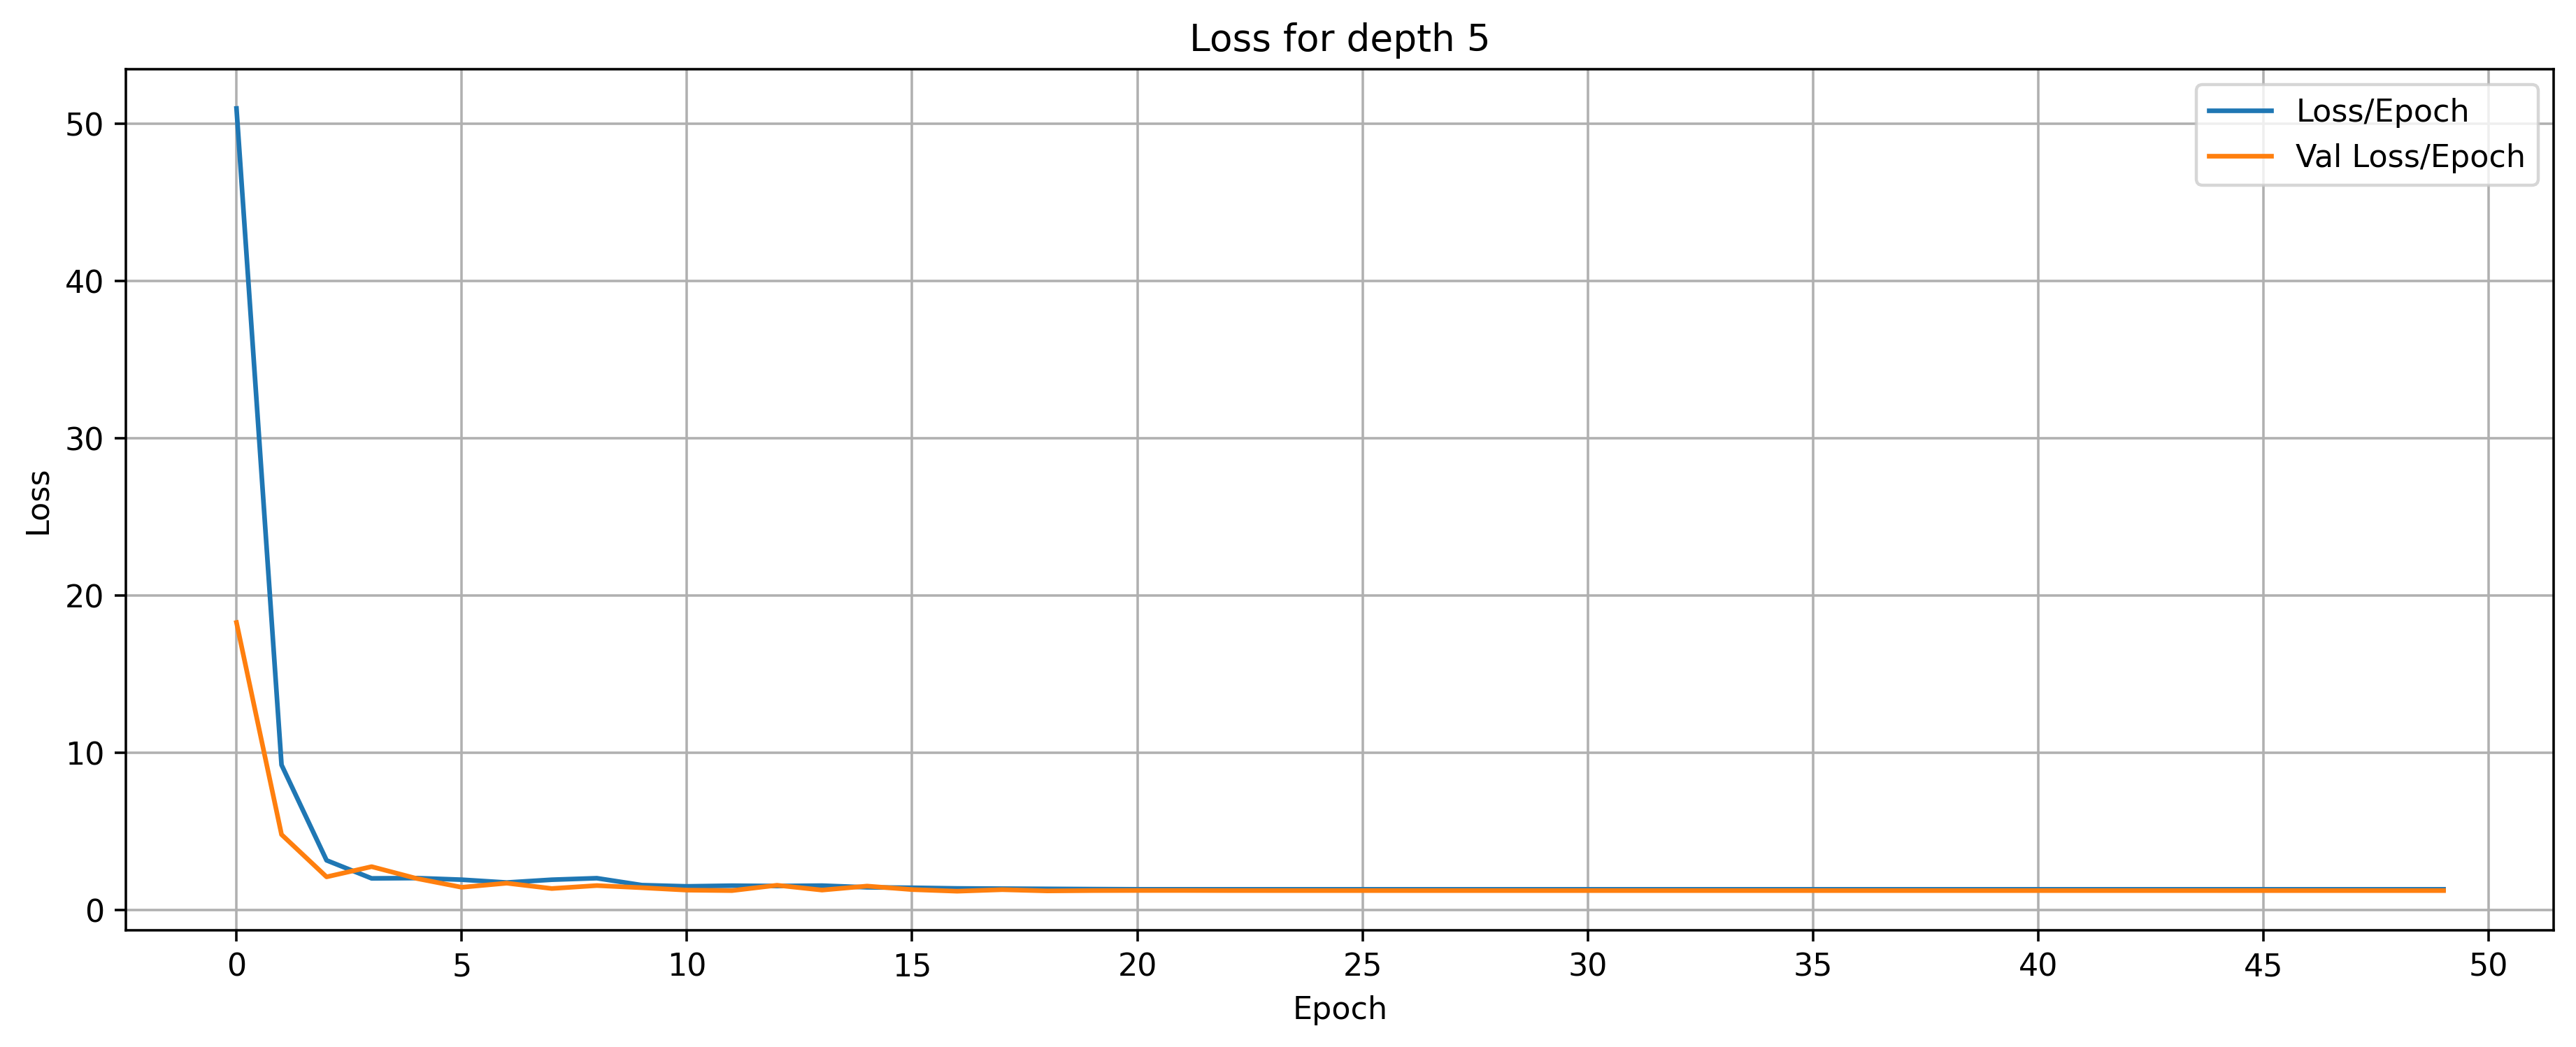

In [25]:
plot_history(history_model2, n_layers)

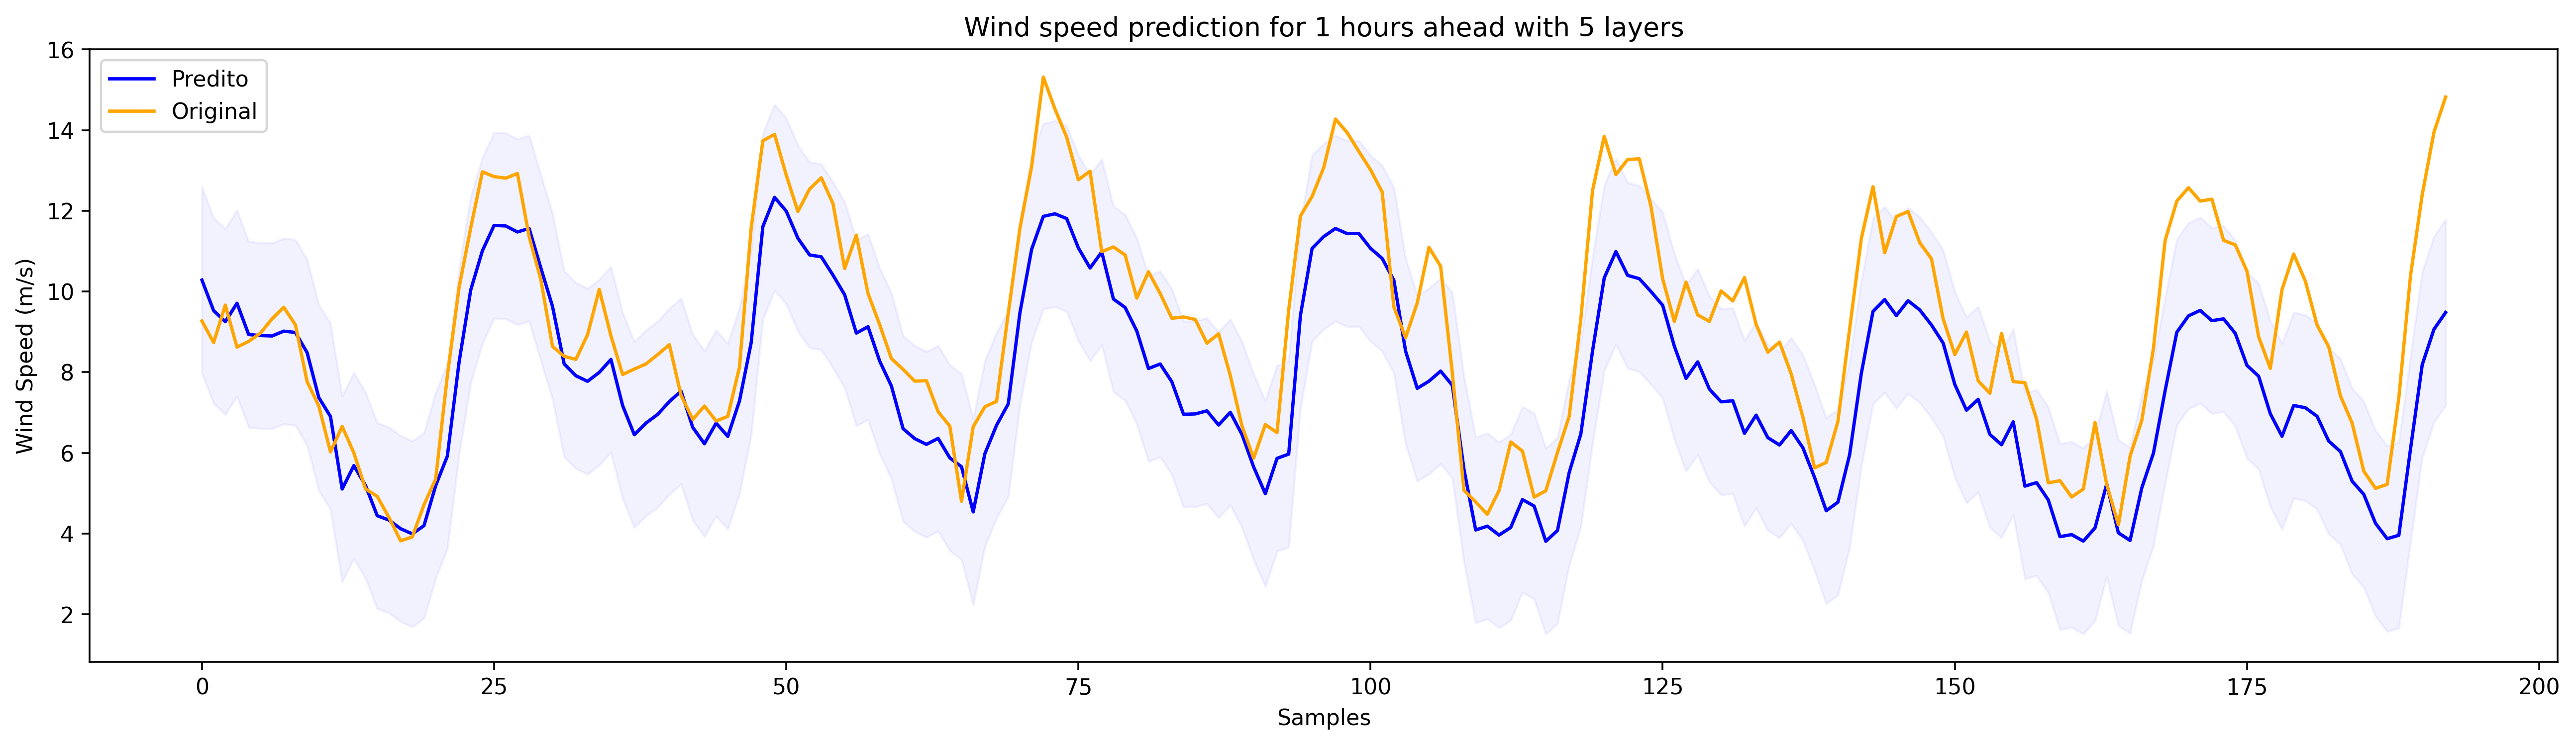

In [26]:
y_pred2 = model2.predict(X_test_scaled,verbose=0)
mean_predictions, mean_error_normal, mean_error_left_normal, mean_error_right_normal = get_mean_left_right_error_interval(model, scaler_x, X_val, y_val, y_test, y_pred2)
plot_prediction_versus_observed(n_layers, y_test, y_pred2, mean_error_normal)


In [27]:
all_analysis2 = quantitative_analysis(y_test, [y_pred2])
all_analysis2

MAE: 1.5874049921820175
MSE: 3.668650918121449
NMSE: 0.5016773826661798
RMSE: 1.9153722661982575
NRMSE: 0.7082918767472769
R: 0.8976730295909989
R²: 0.4957097142991005
Fator de 2: 1.0


,MAE,MSE,NMSE,RMSE,NRMSE,R,R²,Fator de 2
Index,,,,,,,,
1 depth,1.587405,3.668651,0.501677,1.915372,0.708292,0.897673,0.49571,1.0
Média,1.587405,3.668651,0.501677,1.915372,0.708292,0.897673,0.49571,1.0


In [28]:
verify_distribution_wilcoxtest(y_pred[:,0],y_pred2[:,0], 0.05)

Statistics=421.000, p=0.000
Different distribution (reject H0)


(421.0, 1.2459548396450962e-30)